In this study, we look at how the difference between trolley and the average of the  neighboring stations (st 21 and 23). In this data set, the trolley is directly underneath station 22.
The difference has been made positive (absolute value of the difference)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import math

#import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old
import allantools

In [2]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':10, 'family':'serif'})

def difference(y, avgt):      ##Compresses an array by averaging over the given averaging time to "bin" the data, difference is a misleading name
    t = np.arange(int(avgt) , len(y), int(avgt))
    N = len(t)
    Sum = 0
    avgdiff = np.array([])
    for i in y:
        Sum += i
        if (np.where(y == i)[0][0]% avgt == 0) and (np.where(y == i)[0][0] > 0):
            avg = Sum/avgt
            Sum = 0
            avgdiff = np.append(avgdiff, avg)
            
        
    return (t,avgdiff)

def MovingAvg(x, bin_size):
    i = 0
    avg = np.array([])
    while (i < len(x) - bin_size):
        Sum = 0
        j = 0
        while (j < bin_size):
            Sum += x[i + j]
            j += 1
        avg = np.append(avg, Sum/bin_size)
        if(i % 86400 == 0):
            print(str(i) + "iterations done")
        i +=1
    return avg
        
def line(x,m,b): #just a line equation
    return m*x + b

def Multiplot(x_data, y_data, height, width, dimension, sublabels = None, x_axis_labels = None, y_axis_labels = None, figname = None, CST = False, daylines = False, day_offset = 0, logscale = False, day_label = ""):
    #x_data is an array containing arrays with the different data to plot
    #y_data ""
    #width is the width of the whole figure in inches
    #height is the height of the whole figure in inches
    #dimension is an array containing the dimensions of the plot figure np.array([3,2])  would correspond to 6 plots (3 rows, 2 cols)
    #x_axis_labels labels is an array containing the labels on the subplots
    #Similarly for y
    #sublabels are the titles are the subplots (1 x n array of strings), can just be 1 x 1 if all the same
    #Figname is the name of the plot
    #CST will convert the x-axis data into CST time
    #Daylines will plot red lines to show days.
    #day_offset in case we want the 24 hour mark to be somewhere else other than just 24 hours from the start
    for i in range(len(x_data)):
        if len(x_data[i]) != len(y_data[i]):
            print("The dimensions of x[" + str(i) + "] and y[" + str(i) + "] do not match")
    
    equal_x_labels = True
    for k in range(len(x_axis_labels)):
        for l in range(len(x_axis_labels)):
            if k != l:
                if  x_axis_labels[k] != x_axis_labels:
                    equal_x_labels = False
                    
    equal_y_labels = True
    for k in range(len(y_axis_labels)):
        for l in range(len(y_axis_labels)):
            if k != l:
                if  y_axis_labels[k] != y_axis_labels:
                    equal_y_labels = False
    day = np.array([86400,86400])
    fig, axs = plt.subplots(dimension[0], dimension[1], constrained_layout=True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            axs[i,j].plot(x_data[dimension[1] * i + j], y_data[dimension[1] * i + j])
            if equal_x_labels:
                axs[i,j].set_xlabel(x_axis_labels[0])
            else:
                axs[i,j].set_xlabel(x_axis_labels[dimension[1] * i + j])
            if equal_y_labels:
                axs[i,j].set_ylabel(y_axis_labels[0])
            else:
                axs[i,j].set_ylabel(y_axis_labels[dimension[1] * i + j])
            axs[i,j].set_title(sublabels[dimension[1] * i + j])
            if daylines:
                days = int((x_data[dimension[1] * i + j].max() - x_data[dimension[1] * i + j].min()) / 86400)
                for n in range(days):
                    axs[i,j].plot(day * (n+1) + day_offset + x_data[dimension[1] * i + j][0], [y_data[dimension[1] * i + j].min(), y_data[dimension[1] * i + j].max()], 'r', label = day_label)
                    axs[i,j].legend()
            if logscale:
                axs[i,j].set_xscale('log')
                axs[i,j].set_yscale('log')
            if CST:
                plt_unix_time_to_CST(axs[i,j])
    fig.suptitle(figname)

def ArrayRound(array, value):
    #For a 1-D array of values that are non-decreasing everywhere. Returns the element of the array closest to the value given
    inf = -1
    sup = -1
    if array[0] >= value:
        return array[0]
    else:
        for number in array:
            if number <= value:
                inf = number
        if inf == value:
            return value
        else:
            sup = array[np.where(array == inf)[0] +1]
            if abs(inf - value) < abs(sup - value):
                return inf
            elif abs(inf-value) > abs(sup - value):
                return sup
            else:
                print("The closest the value provided is exactly in between two elements of the array, the lower element has been returned.")
                return inf
        
    
def DayLineFit(time_data, y_data, start):
    #Fits lines on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    slopes = np.array([])
    intercepts = np.array([])
    test = np.array([step, step + (day*difference)])
    while step + 86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference)])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]]])
        z = np.polyfit(x,y,1)
        slopes = np.append(slopes, z[0])
        intercepts = np.append(intercepts, z[1])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return slopes, intercepts

def DayParFit(time_data, y_data, start):
    #Fits parabola on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    a = np.array([])
    b = np.array([])
    c = np.array([])
    while step + 2*86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference), step + (2*(day*difference))])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]], y_data[np.where(time_data == step + (2*(day*difference)))[0]]])
        z = np.polyfit(x,y,2)
        a = np.append(a, z[0])
        b = np.append(b, z[1])
        c = np.append(c, z[2])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return a, b, c

def LogSlope(x,y,a): #Returns the slope of a graph at x = a, a is the actual number, not log of the point of interest.
    figwidth = 13
    figheight = 5
    a = ArrayRound(x,a)
    t = np.where(x == a)[0][0]
    diff_y32 = np.log10(y[t + 1]) - np.log10(y[t])
    diff_x32 = np.log10(x[t + 1]) - np.log10(x[t])
    diff_y21 = np.log10(y[t]) - np.log10(y[t-1])
    diff_x21 = np.log10(x[t]) - np.log10(x[t-1])
    m = (.5*(diff_y32/diff_x32)) + (.5*(diff_y21/diff_x21))
    b = np.log10(y[t]) - m * np.log10(x[t])
    line = (10** b) * (x ** m)
    
    fig, axs = plt.subplots(1, 1, constrained_layout=True)
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    axs.plot(x,y)
    axs.plot(x, line, 'c', label = "y = " + str(np.round(m,2)) + "x + " + str(np.round(b, 2)))
    axs.plot([x[t]], [y[t]],'o', 'k')
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.legend()
    axs.set_ylim(min(y), max(y))
    axs.set_aspect('equal')
    plt.show()
    
def cos(x, A, phi):
    period = 86400
    return A * np.cos(2 * np.pi * x / period  + phi)

def ResSquare(obs, exp):
    s = 0
    if(len(obs)!= len(exp)):
        print("The length of the arrays in the ResSquare function are not equal")
    for i in range(len(obs)):
        s += (obs[i] - exp[i])**2
    return s

def Variance(obs, exp, dof):
    return ResSquare(obs, exp)/dof

def Chi2(obs, exp, variance):
    return ResSquare(obs, exp)/variance

def Ftest(chi21, chi22, nu2):
    return nu2 * (chi21 - chi22) / chi22


def Harmonics(x, y, variance, GuessForAAndPhi = None): #Fitting function with F test included, this is only for Cosine  as of now.
    vars1, cov1 = curve_fit(cos, x, y, GuessForAAndPhi)
    period = 86400
    A = vars1[0]
    phi = vars1[1]
    w = 2 * np.pi /period
    def harm2(x, B):
        return(cos(x, A, phi) + B * np.cos(2*w*x + phi))
    vars2, cov2 = curve_fit(harm2, x, y)
    B = vars2[0]
    chi21 = Chi2(y, cos(x, A, phi), variance)
    chi22 = Chi2(y, harm2(x,B), variance)
    terms = 1
    nu2 = len(x) - terms - 1
    F = Ftest(chi21, chi22, nu2)
    print("F_1,2 = " + str(F) + "would you like to add another term? yes[y], no[n]")
    addTerm = raw_input()
    Y = y - harm2(x,B)
    Amplitudes = np.array([phi,A])
    zeros = np.zeros(len(Y))
    if(addTerm == 'y'):
        Amplitudes = np.append(Amplitudes, B)
        
    while addTerm == 'y':
        terms += 1
        def NewTerm(t, C):
            return C * np.cos((terms + 1) * w * t + phi)
        vars3, cov3 = curve_fit(NewTerm, x, Y)
        C = vars3[0]
        chi21 = Chi2(Y,zeros, variance)
        chi22 = Chi2(Y, NewTerm(x,C), variance)
        nu2 = len(x) - terms - 1
        F = Ftest(chi21, chi22, nu2)
        print("F_" + str(terms) + "," + str(terms + 1) + " = " + str(F) + "would you like to add another term? yes[y], no[n]")
        addTerm = raw_input()
        if (addTerm == 'y'):
            Amplitudes = np.append(Amplitudes, C)
        Y = Y - NewTerm(x, C)
    print("You entered something other than y, no more harmonics added. Last harmonic was number " + str(terms))
    print("All you need is to use the fuction BestFit and enter the coefficient array output by this function. The first coefficient is phi")
    return Amplitudes

def BestFit(x, Amplitudes): #Only use arrays output by the Harmonics function if you are unsure of how this function works. First element is phi, rest are amplitude coeff.
    Coeff = Amplitudes
    period = 86400
    w = 2 * np.pi / period
    phi = Amplitudes[0]
    Sum = Coeff[1] * np.cos(w * x + phi) 
    for i in range(len(Amplitudes) - 2):
        Sum += Coeff[i + 2] * np.cos((i + 2)*w*x + phi)
    return Sum

In [3]:
filename = 'hdf5/superlong_1.h5'
sl_interp_df = pd.read_hdf(filename)
#sl_interp_df.head()

In [4]:
sl_moment_df = helper.calc_moment_df(sl_interp_df)

Finished calculating all moments for 252363 events.                                          


In [5]:
#Running before remmoval of data points to show the difference in the allan deviations.
T = sl_moment_df.index.to_numpy()

st21m1_list = sl_moment_df["st21,m1"].to_numpy()
st23m1_list = sl_moment_df["st23,m1"].to_numpy()
trm1_list   = sl_moment_df["tr,m1"].to_numpy()

st21m2_list = sl_moment_df["st21,m2"].to_numpy()
st23m2_list = sl_moment_df["st23,m2"].to_numpy()
trm2_list   = sl_moment_df["tr,m2"].to_numpy()

trm3_list   = sl_moment_df["tr,m3"].to_numpy()
st21m3_list = sl_moment_df["st21,m3"].to_numpy()
st23m3_list = sl_moment_df["st23,m3"].to_numpy()

st21m4_list = sl_moment_df["st21,m4"].to_numpy()
st23m4_list = sl_moment_df["st23,m4"].to_numpy()
trm4_list   = sl_moment_df["tr,m4"].to_numpy()

st21m5_list = sl_moment_df["st21,m5"].to_numpy()
st23m5_list = sl_moment_df["st23,m5"].to_numpy()
trm5_list   = sl_moment_df["tr,m5"].to_numpy()

st21m6_list = sl_moment_df["st21,m6"].to_numpy()
st23m6_list = sl_moment_df["st23,m6"].to_numpy()
trm6_list   = sl_moment_df["tr,m6"].to_numpy()

#station averages
sa1 = (st21m1_list + st23m1_list)/2
sa2 = (st21m2_list + st23m2_list)/2
sa3 = (st21m3_list + st23m3_list)/2
sa4 = (st21m4_list + st23m4_list)/2
sa5 = (st21m5_list + st23m5_list)/2
sa6 = (st21m6_list + st23m6_list)/2
# difference between the trolley and the station average
st1 = abs(trm1_list - sa1) # m1 measured by trolley is higher always             
st2 = abs(trm2_list - sa2) # m2 measured by trolley is higher always
st3 = abs(trm3_list - sa3) # m3 measured by trolley is higher always
st4 = abs(trm4_list - sa4) # m4 measured by trolley is higher always
st5 = abs(trm5_list - sa5) # m5 measured by trolley is higher always
st6 = abs(trm6_list - sa6) # m6 measured by trolley is higher always

t = np.logspace(0, math.log(len(st21m1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data

#Computing the Allan Deviations of the differences:
(tb1, adb1, ade, adn) = allantools.oadev(st1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(tb2, adb2, ade, adn) = allantools.oadev(st2, rate=r, data_type="freq", taus = t)
(tb3, adb3, ade, adn) = allantools.oadev(st3, rate=r, data_type="freq", taus = t)  
(tb4, adb4, ade, adn) = allantools.oadev(st4, rate=r, data_type="freq", taus = t)
(tb5, adb5, ade, adn) = allantools.oadev(st5, rate=r, data_type="freq", taus = t) 
(tb6, adb6, ade, adn) = allantools.oadev(st6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgtb1 = tb1[np.where(adb1==adb1.min())][0]
avgtb2 = tb2[np.where(adb2==adb2.min())][0]
avgtb3 = tb3[np.where(adb3==adb3.min())][0]
avgtb4 = tb4[np.where(adb4==adb4.min())][0]
avgtb5 = tb5[np.where(adb5==adb5.min())][0]
avgtb6 = tb6[np.where(adb6==adb6.min())][0]

In [6]:
run_start = sl_moment_df.index.values[0] #I forgot to keep the times on arrays, was still getting used to CST time
time_deleted = 61200
sl_moment_df = sl_moment_df.drop(np.arange(run_start, run_start + time_deleted)) #deleting the drift part

In [7]:
T = sl_moment_df.index.to_numpy()
st21m1_list = sl_moment_df["st21,m1"].to_numpy()
st23m1_list = sl_moment_df["st23,m1"].to_numpy()
trm1_list   = sl_moment_df["tr,m1"].to_numpy()

st21m2_list = sl_moment_df["st21,m2"].to_numpy()
st23m2_list = sl_moment_df["st23,m2"].to_numpy()
trm2_list   = sl_moment_df["tr,m2"].to_numpy()

trm3_list   = sl_moment_df["tr,m3"].to_numpy()
st21m3_list = sl_moment_df["st21,m3"].to_numpy()
st23m3_list = sl_moment_df["st23,m3"].to_numpy()

st21m4_list = sl_moment_df["st21,m4"].to_numpy()
st23m4_list = sl_moment_df["st23,m4"].to_numpy()
trm4_list   = sl_moment_df["tr,m4"].to_numpy()

st21m5_list = sl_moment_df["st21,m5"].to_numpy()
st23m5_list = sl_moment_df["st23,m5"].to_numpy()
trm5_list   = sl_moment_df["tr,m5"].to_numpy()

st21m6_list = sl_moment_df["st21,m6"].to_numpy()
st23m6_list = sl_moment_df["st23,m6"].to_numpy()
trm6_list   = sl_moment_df["tr,m6"].to_numpy()

In [8]:
#station averages
sa1 = (st21m1_list + st23m1_list)/2
sa2 = (st21m2_list + st23m2_list)/2
sa3 = (st21m3_list + st23m3_list)/2
sa4 = (st21m4_list + st23m4_list)/2
sa5 = (st21m5_list + st23m5_list)/2
sa6 = (st21m6_list + st23m6_list)/2
# difference between the trolley and the station average
st1 = abs(trm1_list - sa1) # m1 measured by trolley is higher always             
st2 = abs(trm2_list - sa2) # m2 measured by trolley is higher always
st3 = abs(trm3_list - sa3) # m3 measured by trolley is higher always
st4 = abs(trm4_list - sa4) # m4 measured by trolley is higher always
st5 = abs(trm5_list - sa5) # m5 measured by trolley is higher always
st6 = abs(trm6_list - sa6) # m6 measured by trolley is higher always

In [9]:
t = np.logspace(0, math.log(len(st21m1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data

#Computing the Allan Deviations of the differences:
(tt1, adt1, ade, adn) = allantools.oadev(st1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(tt2, adt2, ade, adn) = allantools.oadev(st2, rate=r, data_type="freq", taus = t)
(tt3, adt3, ade, adn) = allantools.oadev(st3, rate=r, data_type="freq", taus = t)  
(tt4, adt4, ade, adn) = allantools.oadev(st4, rate=r, data_type="freq", taus = t)
(tt5, adt5, ade, adn) = allantools.oadev(st5, rate=r, data_type="freq", taus = t) 
(tt6, adt6, ade, adn) = allantools.oadev(st6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgtt1 = tt1[np.where(adt1==adt1.min())][0]
avgtt2 = tt2[np.where(adt2==adt2.min())][0]
avgtt3 = tt3[np.where(adt3==adt3.min())][0]
avgtt4 = tt4[np.where(adt4==adt4.min())][0]
avgtt5 = tt5[np.where(adt5==adt5.min())][0]
avgtt6 = tt6[np.where(adt6==adt6.min())][0]

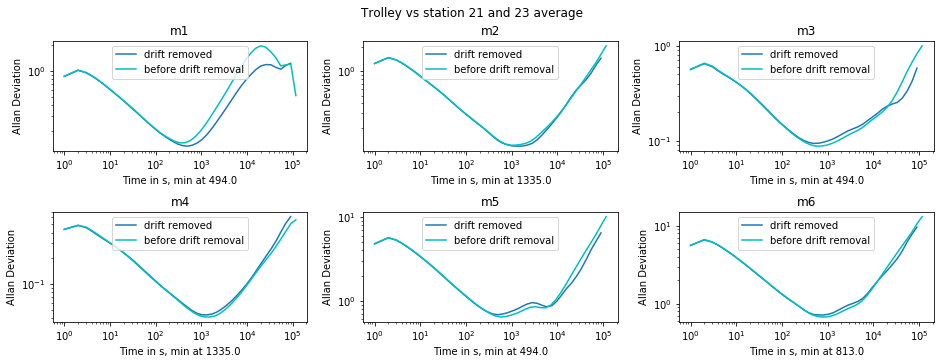

In [10]:
#Plots Allan Deviations:
day  = np.array([86400, 86400])
adt1m = np.array([min(adt1), max(adt1)]) #Trolley vs. st avg
adt2m = np.array([min(adt2), max(adt2)])
adt3m = np.array([min(adt3), max(adt3)])
adt4m = np.array([min(adt4), max(adt4)])
adt5m = np.array([min(adt5), max(adt5)])
adt6m = np.array([min(adt6), max(adt6)])

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)
axs[0,0].plot(tt1, adt1, label = "drift removed")
axs[0,0].plot(tb1,adb1, 'c', label ="before drift removal")
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].legend()
axs[0,0].set_xlabel("Time in s, min at " + str(avgtt1))
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(tt2,adt2, label = "drift removed")
axs[0,1].plot(tb2,adb2, 'c', label ="before drift removal")
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend()
axs[0,1].set_xlabel("Time in s, min at " + str(avgtt2))
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(tt3,adt3, label = "drift removed")
axs[0,2].plot(tb3,adb3, 'c', label ="before drift removal")
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()
axs[0,2].set_xlabel("Time in s, min at " + str(avgtt3))
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(tt4,adt4, label = "drift removed")
axs[1,0].plot(tb4,adb4, 'c', label ="before drift removal")
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend()
axs[1,0].set_xlabel("Time in s, min at " + str(avgtt4))
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(tt5,adt5, label = "drift removed")
axs[1,1].plot(tb5,adb5, 'c', label ="before drift removal")
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].legend()
axs[1,1].set_xlabel("Time in s, min at " + str(avgtt5))
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(tt6,adt6, label = "drift removed")
axs[1,2].plot(tb6,adb6, 'c', label ="before drift removal")
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].legend()
axs[1,2].set_xlabel("Time in s, min at " + str(avgtt6))
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
fig.suptitle("Trolley vs station 21 and 23 average")

plt.show()

In [11]:
#Fitting a line to the unbinned data (Correlation)
vars1, cov1 = curve_fit(line,trm1_list, sa1)
print("m = " + str(vars1[0]) + " +- " + str(cov1[0]))
vars2, cov2 = curve_fit(line,trm2_list, sa2)
print("m = " + str(vars2[0]) + " +- " + str(cov2[0]))
vars3, cov3 = curve_fit(line,trm3_list, sa3)
print("m = " + str(vars3[0]) + " +- " + str(cov3[0]))
vars4, cov4 = curve_fit(line,trm4_list, sa4)
print("m = " + str(vars4[0]) + " +- " + str(cov4[0]))
vars5, cov5 = curve_fit(line,trm5_list, sa5)
print("m = " + str(vars5[0]) + " +- " + str(cov5[0]))
vars6, cov6 = curve_fit(line,trm6_list, sa6)
print("m = " + str(vars6[0]) + " +- " + str(cov6[0]))

m = 0.9841734607862253 +- [ 4.53797384e-09 -2.29723320e-04]
m = 0.7204070386300616 +- [3.12441660e-06 8.36202692e-05]
m = 0.41532725792569763 +- [4.53697525e-06 6.50321165e-04]
m = 0.39569545381441124 +- [1.90408037e-06 4.51558594e-04]
m = 8.298643814026594 +- [0.00072733 0.0372274 ]
m = 0.549564852895625 +- [ 0.00109201 -0.13756966]


Text(0.5,0.98,'trolley and st21&23 average')

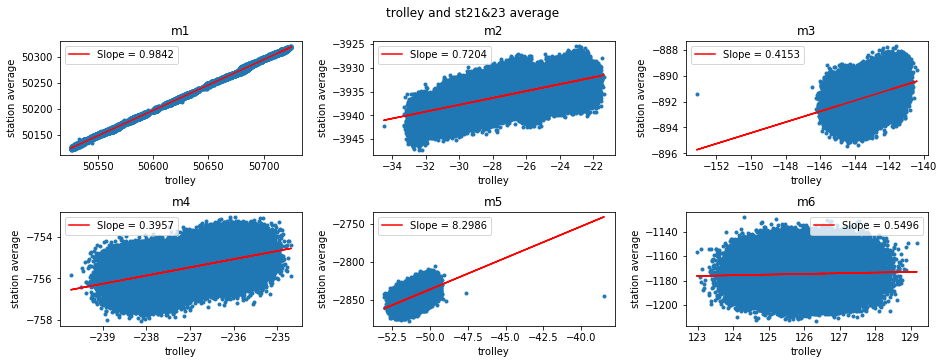

In [12]:
#Plotting the data together with the line of best fit.
fig, axs = plt.subplots(2,3, constrained_layout = True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(trm1_list, sa1,'.')
axs[0,0].plot(trm1_list, line(trm1_list, *vars1), 'r', label = "Slope = " + str(round(vars1[0], 4)))
axs[0,0].set_xlabel("trolley")
axs[0,0].set_ylabel("station average")
axs[0,0].set_title("m1")
axs[0,0].legend()

axs[0,1].plot(trm2_list, sa2,'.')
axs[0,1].plot(trm2_list, line(trm2_list, *vars2), 'r', label = "Slope = " + str(round(vars2[0], 4)))
axs[0,1].set_xlabel("trolley")
axs[0,1].set_ylabel("station average")
axs[0,1].set_title("m2")
axs[0,1].legend()

axs[0,2].plot(trm3_list, sa3,'.')
axs[0,2].plot(trm3_list, line(trm3_list, *vars3), 'r', label = "Slope = " + str(round(vars3[0], 4)))
axs[0,2].set_xlabel("trolley")
axs[0,2].set_ylabel("station average")
axs[0,2].set_title("m3")
axs[0,2].legend()

axs[1,0].plot(trm4_list, sa4,'.')
axs[1,0].plot(trm4_list, line(trm4_list, *vars4), 'r', label = "Slope = " + str(round(vars4[0], 4)))
axs[1,0].set_xlabel("trolley")
axs[1,0].set_ylabel("station average")
axs[1,0].set_title("m4")
axs[1,0].legend()

axs[1,1].plot(trm5_list, sa5,'.')
axs[1,1].plot(trm5_list, line(trm5_list, *vars5), 'r', label = "Slope = " + str(round(vars5[0], 4)))
axs[1,1].set_xlabel("trolley")
axs[1,1].set_ylabel("station average")
axs[1,1].set_title("m5")
axs[1,1].legend()

axs[1,2].plot(trm6_list, sa6,'.')
axs[1,2].plot(trm6_list, line(trm6_list, *vars6), 'r', label = "Slope = " + str(round(vars6[0], 4)))
axs[1,2].set_xlabel("trolley")
axs[1,2].set_ylabel("station average")
axs[1,2].set_title("m6")
axs[1,2].legend()

fig.suptitle("trolley and st21&23 average")

In [13]:
#Bining data
(Tts1_safe, Dts1) =  difference(st1,avgtt1)
print("1 run(s) done")
(Tts2_safe, Dts2) =  difference(st2,avgtt2)
print("2 run(s) done")
(Tts3_safe, Dts3) =  difference(st3,avgtt3)
print("3 run(s) done")
(Tts4_safe, Dts4) =  difference(st4,avgtt4)
print("4 run(s) done")
(Tts5_safe, Dts5) =  difference(st5,avgtt5)
print("5 run(s) done")
(Tts6_safe, Dts6) =  difference(st6,avgtt6)
print("6 run(s) done")

1 run(s) done
2 run(s) done
3 run(s) done
4 run(s) done
5 run(s) done
6 run(s) done


In [14]:
#The time was set to start at 0 in the allan deviation plots, we must add back the starting time
Tts1 = Tts1_safe + run_start + time_deleted
Tts2 = Tts2_safe + run_start + time_deleted
Tts3 = Tts3_safe + run_start + time_deleted
Tts4 = Tts4_safe + run_start + time_deleted
Tts5 = Tts5_safe + run_start + time_deleted
Tts6 = Tts6_safe + run_start + time_deleted

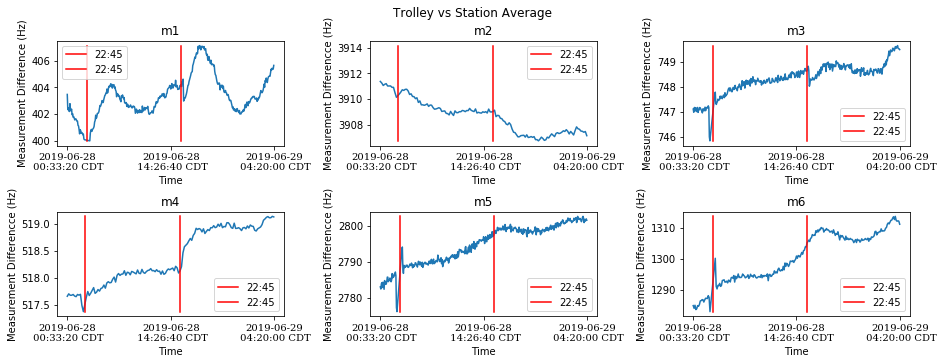

In [15]:
#plotting data
day = np.array([86400, 86400])
lts1 = min(Dts1) #trolley to station average
hts1 = max(Dts1)
lts2 = min(Dts2)
hts2 = max(Dts2)
lts3 = min(Dts3)
hts3 = max(Dts3)
lts4 = min(Dts4)
hts4 = max(Dts4)
lts5 = min(Dts5)
hts5 = max(Dts5)
lts6 = min(Dts6)
hts6 = max(Dts6)

Tts2 = np.delete(Tts2, 0) 
Dts2 = np.delete(Dts2, 0) 
Tts3 = np.delete(Tts3, 0) 
Dts3 = np.delete(Dts3, 0) 
Tts4 = np.delete(Tts4, 0) 
Dts4 = np.delete(Dts4, 0) 
Tts5 = np.delete(Tts5, 0) 
Dts5 = np.delete(Dts5, 0) 


fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(Tts1, Dts1)
#axs[0,0].plot(Tts1, Dts1, '.')
axs[0,0].plot(day - 6400 + run_start, [lts1,hts1], 'r', 2*day - 6400 + run_start, [lts1,hts1], 'r', label = "22:45")
#axs[0,0].plot([Tts1[0] + 61200, Tts1[0] + 61200], [lts1,hts1], 'k', label = "cutoff")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_xticks([Tts1[0], Tts1[len(Tts1)/2], Tts1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(Tts2, Dts2)
#axs[0,1].plot(Tts2, Dts2, '.')
axs[0,1].plot(day - 6400 + run_start, [lts2,hts2], 'r', 2*day - 6400 + run_start, [lts2,hts2], 'r', label = "22:45")
#axs[0,1].plot([Tts2[0] + 61200, Tts2[0] + 61200], [lts2,hts2], 'k', label = "cutoff")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_xticks([Tts2[0], Tts2[len(Tts2)/2], Tts2[-1]])
axs[0,1].set_ylabel("Measurement Differencce (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(Tts3, Dts3)
#axs[0,2].plot(Tts3, Dts3, '.')
axs[0,2].plot(day - 6400 + run_start, [lts3,hts3], 'r', 2*day - 6400 + run_start, [lts3,hts3], 'r', label = "22:45")
#axs[0,2].plot([Tts3[0] + 61200, Tts3[0] + 61200], [lts3,hts3], 'k', label = "cutoff")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([Tts3[0], Tts3[len(Tts3)/2], Tts3[-1]])
axs[0,2].set_ylabel("Measurement Differencce (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tts4, Dts4)
#axs[1,0].plot(Tts4, Dts4, '.')
axs[1,0].plot(day - 6400 + run_start, [lts4,hts4], 'r', 2*day - 6400 + run_start, [lts4,hts4], 'r', label = "22:45")
#axs[1,0].plot([Tts4[0] + 61200, Tts4[0] + 61200], [lts4,hts4], 'k', label = "cutoff")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([Tts4[0], Tts4[len(Tts4)/2], Tts4[-1]])
axs[1,0].set_ylabel("Measurement Differencce (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tts5, Dts5)
#axs[1,1].plot(Tts5, Dts5, '.')
axs[1,1].plot(day - 6400 + run_start, [lts5,hts5], 'r', 2*day - 6400 + run_start, [lts5,hts5], 'r', label = "22:45")
#axs[1,1].plot([Tts5[0] + 61200, Tts5[0] + 61200], [lts5,hts5], 'k', label = "cutoff")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([Tts5[0], Tts5[len(Tts5)/2], Tts5[-1]])
axs[1,1].set_ylabel("Measurement Differencce (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tts6, Dts6)
#axs[1,2].plot(Tts6, Dts6, '.')
axs[1,2].plot(day - 6400 + run_start, [lts6,hts6], 'r', 2*day - 6400 + run_start, [lts6,hts6], 'r', label = "22:45")
#axs[1,2].plot([Tts6[0] + 61200, Tts6[0] + 61200], [lts6,hts6], 'k', label = "cutoff")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([Tts6[0], Tts6[len(Tts6)/2], Tts6[-1]])
axs[1,2].set_ylabel("Measurement Differencce (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Trolley vs Station Average")
plt.show() 
#
#plt.plot(Tts1,Dts1,".")
#plt.plot([86400, 86400], [l1, h1], "r")
#plt.plot([86400*2, 86400*2], [l1, h1], "r")
#plt.title("trm1 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts2,Dts2,".")
#plt.plot([86400, 86400], [l2, h2], "r")
#plt.plot([86400*2, 86400*2], [l2, h2], "r")
#plt.title("trm2 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts3,Dts3,".")
#plt.plot([86400, 86400], [l3, h3], "r")
#plt.plot([86400*2, 86400*2], [l3, h3], "r")
#plt.title("trm3 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts4,Dts4,".")
#plt.plot([86400, 86400], [l4, h4], "r")
#plt.plot([86400*2, 86400*2], [l4, h4], "r")
#plt.title("trm4 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts5,Dts5,".")
#plt.plot([86400, 86400], [l5, h5], "r")
#plt.plot([86400*2, 86400*2], [l5, h5], "r")
#plt.title("trm5 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts6,Dts6,".")
#plt.plot([86400, 86400], [l6, h6], "r")
#plt.plot([86400*2, 86400*2], [l6, h6], "r")
#plt.title("trm6 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()

In [16]:
start1 = Tts1[0]
start2 = Tts2[0]
start3 = Tts3[0]
start4 = Tts4[0]
start5 = Tts5[0]
start6 = Tts6[0]

slopes1, intercepts1 = DayLineFit(Tts1, Dts1, start1)
slope_avg1 = np.average(slopes1)
intercept_avg1 = np.average(intercepts1)
slopes2, intercepts2 = DayLineFit(Tts2, Dts2, start2)
slope_avg2 = np.average(slopes2)
intercept_avg2 = np.average(intercepts2)
slopes3, intercepts3 = DayLineFit(Tts3, Dts3, start3)
slope_avg3 = np.average(slopes3)
intercept_avg3 = np.average(intercepts3)
slopes4, intercepts4 = DayLineFit(Tts4, Dts4, start4)
slope_avg4 = np.average(slopes4)
intercept_avg4 = np.average(intercepts4)
slopes5, intercepts5 = DayLineFit(Tts5, Dts5, start5)
slope_avg5 = np.average(slopes5)
intercept_avg5 = np.average(intercepts5)
slopes6, intercepts6 = DayLineFit(Tts6, Dts6, start6)
slope_avg6 = np.average(slopes6)
intercept_avg6 = np.average(intercepts6)

z1 = np.polyfit(Tts1, Dts1, 1)
z2 = np.polyfit(Tts2, Dts2, 1)
z3 = np.polyfit(Tts3, Dts3, 1)
z4 = np.polyfit(Tts4, Dts4, 1)
z5 = np.polyfit(Tts5, Dts5, 1)
z6 = np.polyfit(Tts6, Dts6, 1)

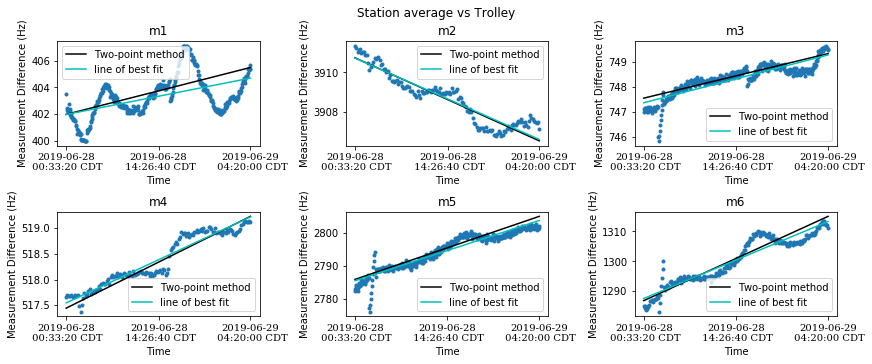

In [17]:
time_deleted = 61200
l1 = Dts1.min()            #Trolley vs st avg
h1 = Dts1.max()
l2 = Dts2.min()
h2 = Dts2.max()
l3 = Dts3.min()
h3 = Dts3.max()
l4 = Dts4.min()
h4 = Dts4.max()
l5 = Dts5.min()
h5 = Dts5.max()
l6 = Dts6.min()
h6 = Dts6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

#axs[0,0].plot(T1 , D1)
axs[0,0].plot(Tts1 , Dts1, '.')
#axs[0,0].plot(day-6400-time_deleted + run_start, [l1,h1], 'r', 2*day-6400-time_deleted + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].plot(Tts1, line(Tts1, np.average(slopes1), np.average(intercepts1)), 'k', label = "Two-point method")
axs[0,0].plot(Tts1, line(Tts1, z1[0], z1[1]), "c", label = "line of best fit")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_xticks([Tts1[0], Tts1[len(Tts1)/2], Tts1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')#

#axs[0,1].plot(T2 , D2)
axs[0,1].plot(Tts2 , Dts2, '.')
#axs[0,1].plot(day-6400-time_deleted + run_start, [l2,h2], 'r', 2*day-6400-time_deleted + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].plot(Tts2, line(Tts2, np.average(slopes2), np.average(intercepts2)), 'k', label = "Two-point method")
axs[0,1].plot(Tts2, line(Tts2, z2[0], z2[1]), "c", label = "line of best fit")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_xticks([Tts2[0], Tts2[len(Tts2)/2], Tts2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

#axs[0,2].plot(T3 , D3)
axs[0,2].plot(Tts3 , Dts3, '.')
#axs[0,2].plot(day-6400-time_deleted + run_start, [l3,h3], 'r', 2*day-6400-time_deleted + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].plot(Tts3, line(Tts3, np.average(slopes3), np.average(intercepts3)), 'k', label = "Two-point method")
axs[0,2].plot(Tts3, line(Tts3, z3[0], z3[1]), "c", label = "line of best fit")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([Tts3[0], Tts3[len(Tts3)/2], Tts3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

#axs[1,0].plot(T4 , D4)
axs[1,0].plot(Tts4 , Dts4, '.')
#axs[1,0].plot(day-6400-time_deleted + run_start, [l4,h4], 'r', 2*day-6400-time_deleted + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].plot(Tts4, line(Tts4, np.average(slopes4), np.average(intercepts4)), 'k', label = "Two-point method")
axs[1,0].plot(Tts4, line(Tts4, z4[0], z4[1]), "c", label = "line of best fit")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([Tts4[0], Tts4[len(Tts4)/2], Tts4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

#axs[1,1].plot(T5 , D5)
axs[1,1].plot(Tts5 , Dts5, '.')
#axs[1,1].plot(day-6400-time_deleted + run_start, [l5,h5], 'r', 2*day-6400-time_deleted + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].plot(Tts5, line(Tts5, np.average(slopes5), np.average(intercepts5)), 'k', label = "Two-point method")
axs[1,1].plot(Tts5, line(Tts5, z5[0], z5[1]), "c", label = "line of best fit")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([Tts5[0], Tts5[len(Tts5)/2], Tts5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

#axs[1,2].plot(T6 , D6)
axs[1,2].plot(Tts6 , Dts6, '.')
#axs[1,2].plot(day-6400-time_deleted + run_start, [l6,h6], 'r', 2*day-6400-time_deleted + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].plot(Tts6, line(Tts6, np.average(slopes6), np.average(intercepts6)), 'k', label = "Two-point method")
axs[1,2].plot(Tts6, line(Tts6, z6[0], z6[1]), "c", label = "line of best fit")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([Tts6[0], Tts6[len(Tts6)/2], Tts6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station average vs Trolley")
plt.show()

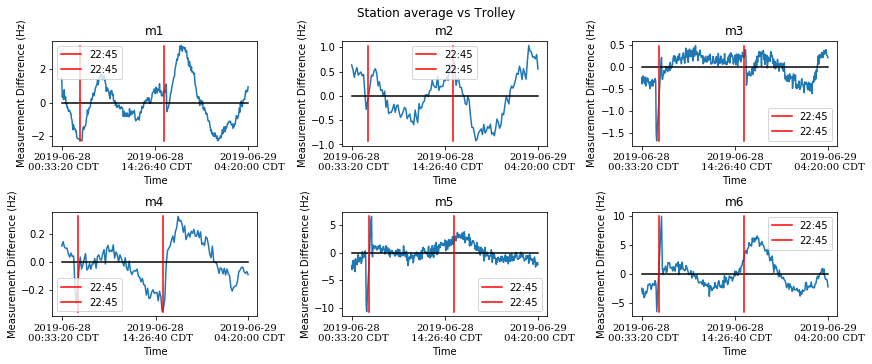

In [18]:
l1 = np.min(Dts1 - line(Tts1, z1[0], z1[1]))            #Trolley vs st 22 line of best fit subtracted.
h1 = np.max(Dts1 - line(Tts1, z1[0], z1[1]))
l2 = np.min(Dts2 - line(Tts2, z2[0], z2[1]))
h2 = np.max(Dts2 - line(Tts2, z2[0], z2[1]))
l3 = np.min(Dts3 - line(Tts3, z3[0], z3[1]))
h3 = np.max(Dts3 - line(Tts3, z3[0], z3[1]))
l4 = np.min(Dts4 - line(Tts4, z4[0], z4[1]))
h4 = np.max(Dts4 - line(Tts4, z4[0], z4[1]))
l5 = np.min(Dts5 - line(Tts5, z5[0], z5[1]))
h5 = np.max(Dts5 - line(Tts5, z5[0], z5[1]))
l6 = np.min(Dts6 - line(Tts6, z6[0], z6[1]))
h6 = np.max(Dts6 - line(Tts6, z6[0], z6[1]))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

axs[0,0].plot(Tts1, Dts1 - line(Tts1, z1[0], z1[1]))
axs[0,0].plot([Tts1.min(), Tts1.max()], [0,0], 'k')
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_xticks([Tts1[0], Tts1[len(Tts1)/2], Tts1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(Tts2, Dts2 - line(Tts2, z2[0], z2[1]))
axs[0,1].plot([Tts2.min(), Tts2.max()], [0,0], 'k')
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_xticks([Tts2[0], Tts2[len(Tts2)/2], Tts2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(Tts3, Dts3 - line(Tts3, z3[0], z3[1]))
axs[0,2].plot([Tts3.min(), Tts3.max()], [0,0], 'k')
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([Tts3[0], Tts3[len(Tts3)/2], Tts3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tts4, Dts4 - line(Tts4, z4[0], z4[1]))
axs[1,0].plot([Tts4.min(), Tts4.max()], [0,0], 'k')
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([Tts4[0], Tts4[len(Tts4)/2], Tts4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tts5, Dts5 - line(Tts5, z5[0], z5[1]))
axs[1,1].plot([Tts5.min(), Tts5.max()], [0,0], 'k')
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([Tts5[0], Tts5[len(Tts5)/2], Tts5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tts6, Dts6 - line(Tts6, z6[0], z6[1]))
axs[1,2].plot([Tts6.min(), Tts6.max()], [0,0], 'k')
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([Tts6[0], Tts6[len(Tts6)/2], Tts6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station average vs Trolley")
plt.show()


In [20]:
corr_diff1 = st1 - np.polyval([slope_avg1, intercept_avg1], T)
vars1, cov1 = curve_fit(cos, T, corr_diff1)
print(vars1)

corr_diff2 = st2 - np.polyval([slope_avg2, intercept_avg2], T)
vars2, cov2 = curve_fit(cos, T, corr_diff2, [.4, 43200])
print(vars2)

corr_diff3 = st3 - np.polyval([slope_avg3, intercept_avg3], T)
vars3, cov3 = curve_fit(cos, T, corr_diff3)
print(vars3)

corr_diff4 = st4 - np.polyval([slope_avg4, intercept_avg4], T)
vars4, cov4 = curve_fit(cos, T, corr_diff4)
print(vars4)

corr_diff5 = st5 - np.polyval([slope_avg5, intercept_avg5], T)
vars5, cov5 = curve_fit(cos, T, corr_diff5)
print(vars5)

corr_diff6 = st6 - np.polyval([slope_avg6, intercept_avg6], T)
vars6, cov6 = curve_fit(cos, T, corr_diff6)
print(vars6)

A1 = vars1[0]
phi1 = vars1[1]

A2 = vars2[0]
phi2 = vars2[1]

A3 = vars3[0]
phi3 = vars3[1]

A4 = vars4[0]
phi4 = vars4[1]

A5 = vars5[0]
phi5 = vars5[1]

A6 = vars6[0]
phi6 = vars6[1]

[-1.37308115  1.84591713]
[-5.62560610e-01  4.32007091e+04]
[-0.17471507  1.19005709]
[-0.1334133   1.26636747]
[ 1.13790062 -0.9712363 ]
[ 3.37060566 -1.01577402]


In [21]:
yy1 = Dts1 - line(Tts1, slope_avg1, intercept_avg1)
yy2 = Dts2 - line(Tts2, slope_avg2, intercept_avg2)

In [22]:
#estimating the variance by taking a chunk of data and making red. chi2 = 1
sample_vals = np.array([])
sample_t = np.array([])
for i in range(15000):
    sample_vals = np.append(sample_vals, corr_diff1[i])
    sample_t    = np.append(sample_t , i)
    
fit = np.polyfit(sample_t, sample_vals, 2)
dof = len(sample_vals) - 3
variance1 = Variance(sample_vals, np.polyval(fit, sample_t), dof)
print(variance1)
print(np.sqrt(variance1))

##Now m2
sample_vals = np.array([])
sample_t = np.array([])
for i in range(15000):
    sample_vals = np.append(sample_vals, corr_diff2[i])
    sample_t    = np.append(sample_t , i)
    
fit = np.polyfit(sample_t, sample_vals, 2)
dof = len(sample_vals) - 3
variance2 = Variance(sample_vals, np.polyval(fit, sample_t), dof)
print(variance2)
print(np.sqrt(variance2))


1.8519087252813602
1.360848531351436
3.7544717270504195
1.9376459240662158


F_1,2 = 5211.930510910988would you like to add another term? yes[y], no[n]
y
F_2,3 = 1716.4292807880909would you like to add another term? yes[y], no[n]
y
F_3,4 = 23.90628047567339would you like to add another term? yes[y], no[n]
n
You entered something other than y, no more harmonics added. Last harmonic was number 3
All you need is to use the fuction BestFit and enter the coefficient array output by this function. The first coefficient is phi


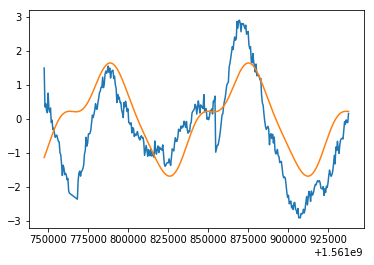

F_1,2 = 0.5598717364097806would you like to add another term? yes[y], no[n]
n
You entered something other than y, no more harmonics added. Last harmonic was number 1
All you need is to use the fuction BestFit and enter the coefficient array output by this function. The first coefficient is phi


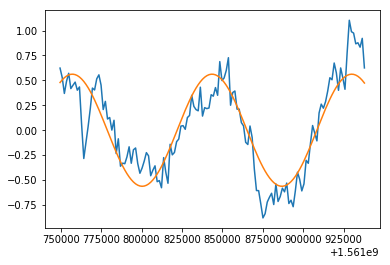

In [23]:

coeff1 = Harmonics(T, corr_diff1, variance1)
harm1 = BestFit(Tts1, coeff1)
plt.plot(Tts1, yy1)
plt.plot(Tts1, harm1)
plt.show()

coeff2 = Harmonics(T, corr_diff2, variance2)
harm2 = BestFit(Tts2, coeff2)
plt.plot(Tts2, yy2)
plt.plot(Tts2, harm2)
plt.show()

harm1 = BestFit(T, coeff1)
harm2 = BestFit(T, coeff2)


In [24]:
m1 = MovingAvg(st1 - np.polyval([slope_avg1, intercept_avg1],T), 7200)
print("m1 done")


0iterations done
86400iterations done
172800iterations done
m1 done
0iterations done
86400iterations done
172800iterations done


In [27]:
m2 = MovingAvg(st2 - np.polyval([slope_avg2, intercept_avg2],T), 7200)

0iterations done
86400iterations done
172800iterations done


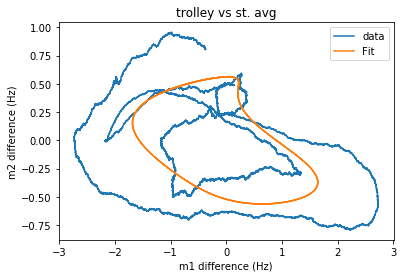

The phase difference is -43198.86320717196


In [29]:
plt.plot(m1, m2, label = "data")
plt.plot(harm1, harm2, label = "Fit")
plt.xlabel("m1 difference (Hz)")
plt.ylabel("m2 difference (Hz)")
plt.title("trolley vs st. avg")
plt.legend()
plt.show()

print("The phase difference is " + str(phi1 - phi2))

In [3]:
#ax^2 + bx + c

a1, b1, c1 = DayParFit(Tts1, Dts1, start1)
#print("a1 = " + str(a1))
#print("b1 = " + str(b1))
#print("c1 = " + str(c1))
print(len(c1))
a1 = np.average(a1)
b1 = np.average(b1)
c1 = np.average(c1)

a2, b2, c2 = DayParFit(Tts2, Dts2, start2)
#print("a2 = " + str(a2))
#print("b2 = " + str(b2))
#print("c2 = " + str(c2))
print(len(c2))
a2 = np.average(a2)
b2 = np.average(b2)
c2 = np.average(c2)

a3, b3, c3 = DayParFit(Tts3, Dts3, start3)
#print("a3 = " + str(a3))
#print("b3 = " + str(b3))
#print("c3 = " + str(c3))
print(len(c3))
a3 = np.average(a3)
b3 = np.average(b3)
c3 = np.average(c3)

a4, b4, c4 = DayParFit(Tts4, Dts4, start4)
#print("a4 = " + str(a4))
#print("b4 = " + str(b4))
#print("c4 = " + str(c4))
print(len(c4))
a4 = np.average(a4)
b4 = np.average(b4)
c4 = np.average(c4)

a5, b5, c5 = DayParFit(Tts5, Dts5, start5)
#print("a5 = " + str(a5))
#print("b5 = " + str(b5))
#print("c5 = " + str(c5))
print(len(c5))
a5 = np.average(a5)
b5 = np.average(b5)
c5 = np.average(c5)

a6, b6, c6 = DayParFit(Tts6, Dts6, start6)
#print("a6 = " + str(a6))
#print("b6 = " + str(b6))
#print("c6 = " + str(c6))
print(len(c6))
a6 = np.average(a6)
b6 = np.average(b6)
c6 = np.average(c6)


#Ax^2 + Bx + C
A1, B1, C1 = np.polyfit(Tts1, Dts1, 2)
A2, B2, C2 = np.polyfit(Tts2, Dts2, 2)
A3, B3, C3 = np.polyfit(Tts3, Dts3, 2)
A4, B4, C4 = np.polyfit(Tts4, Dts4, 2)
A5, B5, C5 = np.polyfit(Tts5, Dts5, 2)
A6, B6, C6 = np.polyfit(Tts6, Dts6, 2)

print("A1 = " + str(A1))
print("B1 = " + str(B1))
print("C1 = " + str(C1))

print("A2 = " + str(A2))
print("B2 = " + str(B2))
print("C2 = " + str(C2))

print("A3 = " + str(A3))
print("B3 = " + str(B3))
print("C3 = " + str(C3))

print("A4 = " + str(A4))
print("B4 = " + str(B4))
print("C4 = " + str(C4))

print("A5 = " + str(A5))
print("B5 = " + str(B5))
print("C5 = " + str(C5))

print("A6 = " + str(A6))
print("B6 = " + str(B6))
print("C6 = " + str(C6))

NameError: name 'DayParFit' is not defined

In [4]:
l1 = Dts1.min()            #Trolley vs st avg
h1 = Dts1.max()
l2 = Dts2.min()
h2 = Dts2.max()
l3 = Dts3.min()
h3 = Dts3.max()
l4 = Dts4.min()
h4 = Dts4.max()
l5 = Dts5.min()
h5 = Dts5.max()
l6 = Dts6.min()
h6 = Dts6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

#axs[0,0].plot(T1 , D1)
axs[0,0].plot(Tts1 , Dts1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r')#, label = "22:45")
axs[0,0].plot(Tts1, np.polyval(np.array([a1, b1, c1]), Tts1), 'k', label = "Three-point method")
axs[0,0].plot(Tts1, np.polyval(np.array([A1, B1, C1]), Tts1), "c", label = "Parabola of best fit")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1, 36 parabolas')#

#axs[0,1].plot(T2 , D2)
axs[0,1].plot(Tts2 , Dts2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r')#, label = "22:45")
axs[0,1].plot(Tts2, np.polyval(np.array([a2, b2, c2]), Tts2), 'k', label = "Three-point method")
axs[0,1].plot(Tts2, np.polyval(np.array([A2, B2, C2]), Tts2), "c", label = "Parabola of best fit")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2, 13 parabolas')

#axs[0,2].plot(T3 , D3)
axs[0,2].plot(Tts3 , Dts3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r')#, label = "22:45")
axs[0,2].plot(Tts3, np.polyval(np.array([a3, b3, c3]), Tts3), 'k', label = "Three-point method")
axs[0,2].plot(Tts3, np.polyval(np.array([A3, B3, C3]), Tts3), "c", label = "Parabola of best fit")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3, 36 parabolas')

#axs[1,0].plot(T4 , D4)
axs[1,0].plot(Tts4 , Dts4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r')#, label = "22:45")
axs[1,0].plot(Tts4, np.polyval(np.array([a4, b4, c4]), Tts4), 'k', label = "Three-point method")
axs[1,0].plot(Tts4, np.polyval(np.array([A4, B4, C4]), Tts4), "c", label = "Parabola of best fit")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4, 13 parabolas')

#axs[1,1].plot(T5 , D5)
axs[1,1].plot(Tts5 , Dts5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r')#, label = "22:45")
axs[1,1].plot(Tts5, np.polyval(np.array([a5, b5, c5]), Tts5), 'k', label = "Three-point method")
axs[1,1].plot(Tts5, np.polyval(np.array([A5, B5, C5]), Tts5), "c", label = "Parabola of best fit")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5, 36 parabolas')

#axs[1,2].plot(T6 , D6)
axs[1,2].plot(Tts6 , Dts6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r')#, label = "22:45")
axs[1,2].plot(Tts6, np.polyval(np.array([a6, b6, c6]), Tts6), 'k', label = "Three-point method")
axs[1,2].plot(Tts6, np.polyval(np.array([A6, B6, C6]), Tts6), "c", label = "Parabola of best fit")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6, 22 parabolas')
fig.suptitle("Station avg vs Trolley")
plt.show()

NameError: name 'Dts1' is not defined

In [5]:
l1 = np.min(Dts1 - np.polyval([A1, B1, C1], Tts1))            #Trolley vs st avg parabola of best fit subtracted.
h1 = np.max(Dts1 - np.polyval([A1, B1, C1], Tts1))
l2 = np.min(Dts2 - np.polyval([A2, B2, C2], Tts2))
h2 = np.max(Dts2 - np.polyval([A2, B2, C2], Tts2))
l3 = np.min(Dts3 - np.polyval([A3, B3, C3], Tts3))
h3 = np.max(Dts3 - np.polyval([A3, B3, C3], Tts3))
l4 = np.min(Dts4 - np.polyval([A4, B4, C4], Tts4))
h4 = np.max(Dts4 - np.polyval([A4, B4, C4], Tts4))
l5 = np.min(Dts5 - np.polyval([A5, B5, C5], Tts5))
h5 = np.max(Dts5 - np.polyval([A5, B5, C5], Tts5))
l6 = np.min(Dts6 - np.polyval([A6, B6, C6], Tts6))
h6 = np.max(Dts6 - np.polyval([A6, B6, C6], Tts6))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

axs[0,0].plot(Tts1, Dts1 - np.polyval([A1, B1, C1], Tts1))
axs[0,0].plot([Tts1.min(), Tts1.max()], [0,0], 'k')
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(Tts2, Dts2 - np.polyval([A2, B2, C2], Tts2))
axs[0,1].plot([Tts2.min(), Tts2.max()], [0,0], 'k')
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(Tts3, Dts3 - np.polyval([A3, B3, C3], Tts3))
axs[0,2].plot([Tts3.min(), Tts3.max()], [0,0], 'k')
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tts4, Dts4 - np.polyval([A4, B4, C4], Tts4))
axs[1,0].plot([Tts4.min(), Tts4.max()], [0,0], 'k')
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tts5, Dts5 - np.polyval([A5, B5, C5], Tts5))
axs[1,1].plot([Tts5.min(), Tts5.max()], [0,0], 'k')
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tts6, Dts6 - np.polyval([A6, B6, C6], Tts6))
axs[1,2].plot([Tts6.min(), Tts6.max()], [0,0], 'k')
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station average vs Trolley - quad fit")
plt.show()

NameError: name 'np' is not defined

In [6]:
T = sl_moment_df.index.to_numpy() - (run_start + 61200)
t = np.logspace(0, math.log(len(st23m1_list),10), num = 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(t1, ad1, ade, adn) = allantools.oadev(st1 - np.polyval([slope_avg1, intercept_avg1], T), rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(t2, ad2, ade, adn) = allantools.oadev(st2 - np.polyval([slope_avg2, intercept_avg2], T), rate=r, data_type="freq", taus = t)
(t3, ad3, ade, adn) = allantools.oadev(st3 - np.polyval([slope_avg3, intercept_avg3], T), rate=r, data_type="freq", taus = t)  
(t4, ad4, ade, adn) = allantools.oadev(st4 - np.polyval([slope_avg4, intercept_avg4], T), rate=r, data_type="freq", taus = t)
(t5, ad5, ade, adn) = allantools.oadev(st5 - np.polyval([slope_avg5, intercept_avg5], T), rate=r, data_type="freq", taus = t) 
(t6, ad6, ade, adn) = allantools.oadev(st6 - np.polyval([slope_avg6, intercept_avg6], T), rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgt1 = t1[np.where(ad1==ad1.min())][0]
avgt2 = t2[np.where(ad2==ad2.min())][0]
avgt3 = t3[np.where(ad3==ad3.min())][0]
avgt4 = t4[np.where(ad4==ad4.min())][0]
avgt5 = t5[np.where(ad5==ad5.min())][0]
avgt6 = t6[np.where(ad6==ad6.min())][0]

#Plots Allan Deviation
day  = np.array([86400, 86400])
ad1m = np.array([min(ad1), max(ad1)])
ad2m = np.array([min(ad2), max(ad2)])
ad3m = np.array([min(ad3), max(ad3)])
ad4m = np.array([min(ad4), max(ad4)])
ad5m = np.array([min(ad5), max(ad5)])
ad6m = np.array([min(ad6), max(ad6)])

fig, axs = plt.subplots(2, 3, constrained_layout=True) #This is St22 vs Trolley
fig.set_figheight(5)
fig.set_figwidth(13)
axs[0,0].plot(t1, ad1, label = "After corrections")
axs[0,0].plot(tb1, adb1, 'c', label = "before drift removal")
axs[0,0].plot([86400,86400],[.01,3], 'r')
axs[0,0].set_xscale('log')
axs[0,0].set_ylim(.01,10)                                                                          
axs[0,0].set_yscale('log')
axs[0,0].legend()
axs[0,0].set_xlabel("Time in s")
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(t2,ad2, label = "After corrections")
axs[0,1].plot(tb2,adb2, 'c', label = "before drift removal")
axs[0,1].plot([86400,86400],[.01,3], 'r')
axs[0,1].set_ylim(.01,10)                                                                          
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend()
axs[0,1].set_xlabel("Time in s")
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(t3,ad3, label = "After corrections")
axs[0,2].plot(tb3,adb3, 'c', label = "before drift removal")
axs[0,2].plot([86400,86400],[.01,3], 'r')
axs[0,2].set_ylim(.01,10)                                                                          
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()
axs[0,2].set_xlabel("Time in s")
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(t4,ad4, label = "After corrections")
axs[1,0].plot(tb4,adb4, 'c', label = "before drift removal")
axs[1,0].plot([86400,86400],[.01,3], 'r')
axs[1,0].set_ylim(.01,10)                                                                          
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend()
axs[1,0].set_xlabel("Time in s")
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(t5,ad5, label = "After corrections")
axs[1,1].plot(tb5,adb5, 'c', label = "before drift removal")
axs[1,1].plot([86400,86400],[.01,3], 'r')
axs[1,1].set_ylim(.01,10)                                                                          
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].legend()
axs[1,1].set_xlabel("Time in s")
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(t6,ad6, label = "After corrections")
axs[1,2].plot(tb6,adb6, 'c', label = "before drift removal")
axs[1,2].plot([86400,86400],[.01,3], 'r')
axs[1,2].set_ylim(.01,10)                                                                          
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].legend()
axs[1,2].set_xlabel("Time in s")
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
fig.suptitle("Trolley vs st average")

plt.show()

NameError: name 'sl_moment_df' is not defined